 <style>
.footer {
  position: fixed;
  left: 0;
  bottom: 0;
  width: 100%;
  background-color: white;
  color: grey;
  text-align: left;
  font-size: 8px;
}
</style>
<style>
.header {
  position: fixed;
  left: 0;
  top: 0;
  width: 100%;
  background-color: white;
  color: grey;
  text-align: center;
  font-size: 8px;
}


<img align="left" width="30%" style="padding-right:10px;" src="../Images/Ccom.png">

___
# Computational Problem Set - Being a VGNSS Receiver

## Step 4 Create Observations

## Semme J. Dijkstra


## Objective 

The objective of this step is to perform the necessary coordinate transforms to be able to create observation models and a sky plot.

## Implementation

First we will calculate the Earth Centered Earth Fixed Cartesian WGS84 coordinates. This allows us to calculate the true ranges from our chosen receiver coordinates to the reported locations of the satellite vehicles using Pythagoras’ method. 

Then we will calculate the **true** ranges to the satellites (assuming the ephemeris are free of error).

Subsequently we will calculate the satellite coordinates in both a Cartesian as well as a Polar reference frame.

Finally we will determine which satellites are visible and create a sky plot of the visible satellites


<img align="left" width="30%" style="padding-right:10px;" src="../Images/Ccom.png">

___
# Computational Problem Set - Being a VGNSS Receiver

## Step 4 Create Observations

## Semme J. Dijkstra

<a href="https://teams.microsoft.com/l/channel/19%3afd7ef9823b064892bc126bc40f2b4710%40thread.tacv2/VGNSS?groupId=ed82d769-1aaa-4613-9de0-2dd04127f30a&tenantId=d6241893-512d-46dc-8d2b-be47e25f5666"><img src="../Images/help.png"  title="Ask questions on Teams" align="right" width="10%" alt="Piazza.com\"></a><br><br> 

___
## Objective 

The objective of this step is to perform the necessary coordinate transforms to be able to create observation models and a sky plot.

## Implementation

First we will calculate the Earth Centered Earth Fixed Cartesian WGS84 coordinates. This allows us to calculate the true ranges from our chosen receiver coordinates to the reported locations of the satellite vehicles using Pythagoras’ method. 

Then we will calculate the **true** ranges to the satellites (assuming the ephemeris are free of error).

Subsequently we will calculate the satellite coordinates in both a Cartesian as well as a Polar reference frame.

Finally we will determine which satellites are visible and create a sky plot of the visible satellites

In [73]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np

from numpy import cos,pi,sin,pi,arccos, tan, arctan, arctan2, sqrt
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pathlib import Path
from IPython.display import HTML
vgnss_path=Path('../') # Get the path to the folder containing the mycode folder
print(vgnss_path.resolve())
sys.path.append(str(vgnss_path.resolve())) # add the folder to the list of paths 
data_path=Path('../mydata')

from mycode.gnss import GNSS
from mycode.sp3 import SP3


verbose = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jupyter-semmed/ESCI_OE_771_871


___
# 4 Convert Receiver to Cartesian Coordinates

GNSS use carrier frequencies in the L band i.e., they are microwave signals and thus GNSS are line of sight systems. Assuming they are functioning correctly and no extreme environmental events are occurring this means that satellites are visible when they are above the horizon. Since our ephemerides are given with respect to an ECEF reference frame with an ‘up’ axis aligned to the Earth’s rotation axis we cannot simply glean whether a satellite is visible from the coordinates. However, determining the visibility of a satellite is a simple geometric problem with the right choice of reference system, namely one aligned to the horizon plane at the location of the GNSS receiver, such systems are known as topocentric systems and, just like geocentric systems, come in polar and Cartesian form.

___

## 4.0 Execute the Code from Previous Steps

### Objective:

Get the current state that to represent the state as defined in steps 1. With this VGNSS project we are taking steps throughout the term that rely on previous steps.


### Assignment:

Update the code cell below to execute your step 1 containing the initialization code. Create the object `gnss` of class `GNSS` using the argument `data_path` (see step 3 for an example). Then add the ephemeris data for the `epoch` defined in step 1. 

### Deliverable:

Execute step VGNSS_1 and 


In [75]:
# Start by running your first step
%run VGNSS_1.ipynb

gnss = GNSS(data_path)
gnss.add_next_epoch_ephemeris(epoch.year, epoch.month, epoch.day,
                              epoch.hour, epoch.minute, epoch.second, epoch.microsecond)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jupyter-semmed/ESCI_OE_771_871
Reading SP3 file: ../mydata/igs13381.sp3
Attempting to download precise ephemerides file: igl13381.sp3
Reading SP3 file: ../mydata/igl13381.sp3
Reading rinex nav file: ../mydata/brdc2410.05n


___
## 4.1 Calculate the ECEF Coordinates of the Receiver


### Objective:

Using the geodetic latitude $\phi$, longitude $\lambda$ and ellipsoid height $h$, defined in Step 1, and using the WGS-84 ellipsoid (semi-major axis $a = 6378137$ m, semi-minor axis $b = 6356752.3142$ m), determine the Cartesian ECEF $XYZ$ coordinates for that location.  Use the Transformation ($\phi$,$\lambda$,$h$) to ($XYZ$):

$$\begin{bmatrix}x \\ y \\ z \end{bmatrix} = 
\begin{bmatrix}(N+h)\cos\phi\cos\lambda \\
                (N+h)\cos\phi\sin\lambda \\ 
                \left(N\dfrac{b^2}{a^2}+h\right)\sin\phi \end{bmatrix}$$


Where $N$ is the prime vertical radius of curvature, given by:

$$N=\dfrac{a}{\sqrt{\cos^2\phi + \dfrac{b^2}{a^2}\sin^2\phi}}$$

or, alternatively

$$N=\dfrac{a}{\sqrt{1-e^2\sin^2\phi}}$$

where:

$$ e^2=\dfrac{a^2-b^2}{a^2}=1-\dfrac{b^2}{a^2}$$

$N\cos\phi$ is then the radius of curvature of the parallel through latitude $\phi$ 

N has its minimum value at the equator where $\sin\phi = 0, \cos\phi = 1 \Rightarrow N = a = 6378137$.

N has its maximum value at the poles where $\sin\phi = ±1, \cos\phi = 0 \Rightarrow N = a^2 / b = 6399593.625$.  

<img align="left" width="100%" style="padding-right:30px;" src="../Images/N.png">

___
### 4.1.0 WGS=84 Reference Ellipsoid Definition

For the transformation from geodetic latitude and longitude to ECEF coordinates within WGS-84 we need to determine the prime radius of curvature $N$. As we have seen in 4.1 $N$ is a function of the geodetic latitude $\phi$ and the eccentricity $e$ of the reference ellipsoid. In the code cell the semi-major and -minor axes of the WGS-84 reference ellipsoid are given; calculate the flattening $f$ as `f`, the squared eccentricity $e^2$ as `e2`


In [76]:
# 4.1.0 The parameters for WGS-84
a = 6378137.0000
b = 6356752.3142

# Calculate f, e2 and N
f = ...
e2 = 1-b**2/...

if verbose:
    print('a:  %15.3f' % (a))
    print('b:  %15.3f' % (b))
    print('f:  %15.13f' % (f))
    print('e2: %15.13f' % (e2))

a:      6378137.000
b:      6356752.314
f:  0.0033528106718
e2: 0.0066943800043


Worked Example:

    a:      6378137.000
    b:      6356752.314
    f:  0.0033528106718
    e2: 0.0066943800043


___
### 4.1.1 Prime radius of Curvature

Now calculate the prime radius of curvature $N$ for your $\phi$=`lat` as `N`


In [77]:
# 4.1.1 Prime radius of curvature
N = a/sqrt(1-...*...)

if verbose:
    print('N:  %15.4f' % (N))

N:     6383561.9968


Worked Example:

    N = 
    6383561.9968


___
### 4.1.2 ECEF Coordinates of the given location

Use the transformation defined in 4.1 to calculate the ECEF coordinates of your location and store them in the numpy array `xyz`. This array is to be column-vector of dimensions 3x1. Note that numpy arrays are by default 1 dimensional, that is there is no difference between a row and a column vector!!


In [78]:
# 4.1.2 To create a 3x1 array use xyz = np.array([[1],[2],[3]])

xyz = np.array([[(N+height)*cos(lat)*...,
                [...],
                [(...)*sin(lat)]])

if verbose:
    print('xyz = ')
    for i in range(len(xyz)):
        print('\t%15.3f' % (xyz[i]))

xyz = 
	      36572.327
	   -5514234.862
	    3194349.181


Worked Example:
    
    xyz = 
	      36572.327
	   -5514234.862
	    3194349.181

___
## 4.2 Compute Baselines Spanning the Receiver and Satellite Locations

Calculate the coordinate differences $\Delta x, \Delta y, \Delta z$ between your receiver and each satellite.

Compute the coordinate differences using the Cartesian coordinates for your location `xyz` and the Cartesian GNSS coordinates `eph_gps` and `eph_gln`. Note that the columns of `eph_gps` and `eph_gln` hold the *PRN*$, x, y, z$  of each SV respectively, thus to get the ephemeris as a $3xn$ matrix with the x-coordinates on the $1^{st}$ row, the y-coordinates on the $2^{nd}$ row, and the z-coordinates on the $3^d$ row you would use `eph_gps[:,1:4].T`. To get the coordinate differences you may then simply subtract the coordinates `xyz`

___
### 4.2.0 Calculate the GPS Baselines

First of lets note that `numpy` has two forms of assignment for arrays; the first form of assignment is where we simply state `array_a = array_b`. This results in `array_a` being identical in every sense to `array_b` with the exception of its name i.e., the array holds the same space in memory and if you alter `array_a` you are altering `array_b` as well! Often this is not the intention, we want to make a *copy* of `array_b` and assign it to `array_a` i.e. we want `array_a` to have the same contents as `array_b`, but be located in a different place in memory. In this case if we alter `array_a` `array_b` remains unaffected. In this case we will use the default assignment, which results in a variable pointing at the exact same array - we will do this to make the code more legible. For example the statement:

    Dxyz_gps = gnss.eph_gps_sp3[-1][:, 1:4].T-xyz
    
May be hard to interpret due to the complex nature of the term on the right hand side of the `=` operator. Note that `gnss.eph_gps_sp3[-1]` is in this case the last element of the array `eph_gps_sp3` contained within the object `gnss` of class `GNSS`. All we care about is that it is the GPS ephemeris that we are interested in, so we may say

    eph_gps=gnss.eph_gps_sp3[-1]
    
and then use `eph_gps` to represent this array. Note that this takes very little compute time as the only operations are to create the variable and 'point' it at the array of interest.

    Dxyz_gps = eph_gps[:, 1:4].T-xyz


Calculate the receiver to GPS satellite baselines as `Dxyz_gps` which is a $3xn$ matrix with as the elements on the first row the elements $\Delta x$, the second $\Delta y$ and the third $\Delta z$. Also calculate the number of GPS satellites `n_gps`

In [79]:
# 4.2.0 Calculate the Receiver to GPS SV baselines

eph_gps = gnss.eph_gps_sp3[-1]
Dxyz_gps = eph_gps[:, 1:4].T-xyz
n_gps = Dxyz_gps.shape[1]

if verbose:
    print('n_gps: %d\n' % n_gps)
    print('Dxyz_gps = ')
    for i in range(n_gps):
        print('\t%15.3f %15.3f %15.3f' %
              (Dxyz_gps[0, i], Dxyz_gps[1, i], Dxyz_gps[2, i]))

n_gps: 29

Dxyz_gps = 
	  -14810463.942    -9214095.559    13455967.472
	   13541201.761    26996353.844   -11445216.142
	  -20837451.276    -5980879.278   -15470790.135
	    4277463.860    31010341.499     2010886.176
	   19866345.462    -2252512.679    12298837.345
	   19536837.223    -3005783.142   -18858064.521
	    1056165.459    21661718.797    18312365.287
	   -1693033.087    28948943.100   -15370289.657
	   16587628.101     9753457.220    16646292.719
	   10672113.144    15868113.131   -25254163.661
	  -18260686.195     3057009.440    15996499.532
	  -17546989.320    13977292.747   -21333245.702
	   -1885582.145    -9653405.509    18588638.157
	    1220764.007   -18741048.436   -13693598.206
	   -7683192.651    -8259833.733   -24482868.704
	   17726871.047   -14000316.519    -2361359.148
	  -25475529.807    -1983255.367    -4599143.232
	  -20743125.374    15530137.349     9995455.690
	    9366881.387   -10434915.408   -22023974.206
	    9253116.170   -16307472.396     8916502.5

Worked Example: 
    
    n_gps: 29

    Dxyz_gps = 
	  -14810463.942    -9214095.559    13455967.472
	   13541201.761    26996353.844   -11445216.142
	  -20837451.276    -5980879.278   -15470790.135
	    4277463.860    31010341.499     2010886.176
	   19866345.462    -2252512.679    12298837.345
	   19536837.223    -3005783.142   -18858064.521
	    1056165.459    21661718.797    18312365.287
	   -1693033.087    28948943.100   -15370289.657
	   16587628.101     9753457.220    16646292.719
	   10672113.144    15868113.131   -25254163.661
	  -18260686.195     3057009.440    15996499.532
	  -17546989.320    13977292.747   -21333245.702
	   -1885582.145    -9653405.509    18588638.157
	    1220764.007   -18741048.436   -13693598.206
	   -7683192.651    -8259833.733   -24482868.704
	   17726871.047   -14000316.519    -2361359.148
	  -25475529.807    -1983255.367    -4599143.232
	  -20743125.374    15530137.349     9995455.690
	    9366881.387   -10434915.408   -22023974.206
	    9253116.170   -16307472.396     8916502.587
	  -25076162.220     7074338.432   -12229593.431
	   -6810914.778    24852585.384    13858646.355
	   -9357761.652   -19242133.976     -933274.172
	   25109342.477    14017330.327    -7784749.187
	   -8234024.193    21182403.553   -22326313.357
	  -10486381.208    27685817.508     6844088.972
	   22889767.807    15621546.364   -12058157.340
	   19140580.427   -11855475.027     2253855.407
	   -9084497.639    19470755.871    17197789.811

___
### 4.2.1 Calculate the GLONASS Baselines

Calculate the receiver to GLONASS satellite baselines as `Dxyz_gln` which is a $3xn$ matrix with as the elements on the first row the elements $\Delta x$, the second $\Delta y$ and the third $\Delta z$. Also calculate the number of GPS satellites `n_gps`

In [80]:
## 4.2.1 Calculate the Receiver to GLONASS SV baselines

eph_gln=gnss.eph_gln_sp3[-1]
Dxyz_gln = ...-xyz
n_gln = ...

if verbose:
    print('n_gln: %d\n'%n_gln)
    print('Dxyz_gln = ')
    for i in range(n_gln):
        print('\t%15.3f %15.3f %15.3f'%(Dxyz_gln[0,i],Dxyz_gln[1,i],Dxyz_gln[2,i]))

n_gln: 12

Dxyz_gln = 
	   -2448746.691    -7984160.129    18284016.428
	  -14013514.736     7150982.135    17961015.926
	  -17384618.397    22405518.058     5024035.516
	  -11412690.470    26567751.210   -12134510.027
	   14801947.232     2407343.587   -23825582.469
	   10528886.218   -15641740.719     6337852.910
	  -20754319.335     9638717.726    11107883.884
	    3414179.268    16869382.924    19478742.850
	   20485927.787     1326296.973   -17730858.730
	    4450356.718    -4801088.714   -26089321.968
	  -15083121.192    -4935593.654   -20931970.548
	  -25005552.864      962220.444    -5776282.110


Worked Example: 
    
    n_gln: 12

    Dxyz_gln = 
	   -2448746.691    -7984160.129    18284016.428
	  -14013514.736     7150982.135    17961015.926
	  -17384618.397    22405518.058     5024035.516
	  -11412690.470    26567751.210   -12134510.027
	   14801947.232     2407343.587   -23825582.469
	   10528886.218   -15641740.719     6337852.910
	  -20754319.335     9638717.726    11107883.884
	    3414179.268    16869382.924    19478742.850
	   20485927.787     1326296.973   -17730858.730
	    4450356.718    -4801088.714   -26089321.968
	  -15083121.192    -4935593.654   -20931970.548
	  -25005552.864      962220.444    -5776282.110

___
### 4.3 Compute the True Receiver to Satellite Ranges

Calculate the true geometric range $\rho$ to each GNSS satellite, under the conditions (time and location) of your virtual GNSS fix.

Using the coordinate differences `Dxyz_gps` and `Dxyz_gln` from Step 4.2, compute distances `rho_gps` and `rho_gln` between your location and each GNSS satellite, at the instant of interest.  The equation involved is:

$$\rho = \sqrt{(x_{sat}-x_{rx})^2+(y_{sat}-y_{rx})^2+(z_{sat}-z_{rx})^2}$$ 

or, equivalently:

$$\rho = \sqrt{(\Delta x)^2+(\Delta y)^2+(\Delta z)^2}$$ 

Where:

$\rho$  = the **true** distance to be observed from a specific GNSS satellite

$x_{sat}, y_{sat}, z_{sat}$ = the Cartesian coordinates (in m) for a specific GNSS satellite, at the time of the virtual GNSS fix (from Step 3)
$x_{rx}, y_{rx}, z_{rx}$ = the Cartesian coordinates (in m) for a specific GNSS satellite, at the time of the virtual GNSS fix (from Step 4.1.2)



___
### 4.3.0 Compute the True Receiver to GPS Satellite Ranges

Calculate the true geometric range $\rho$ to each GPS satellite and assign it to the nx1 vector `rho_gps` using the equations in 4.3 and the variable `Dxyz_gps`. Note that it is helpful to know that to extract column `i` from a matrix `A` as a column vector `a` you should use:

    a = A[:,i:i+1]
    
You should use this rather than the at first sight more logical `a = A[:,i]` as that expression would return a one-dimensional array, which is not what we want.


In [81]:
## 4.3.0 Calculate the range from the receiver to each GPS satellite
# First allocate memory by creating a n_gps x 1 2D array
rho_gps=np.zeros((n_gps,1))

for i in range(...):
    rho_gps[i] = sqrt(Dxyz_gps[:,i].T@Dxyz_gps[:,i])
    
if verbose:
    print('rho_gps = ')
    for i in range(n_gps):
        print('\t%15.3f'%(rho_gps[i]))

rho_gps = 
	   22029808.437
	   32297991.246
	   26632980.307
	   31368481.636
	   23473536.066
	   27319394.914
	   28384648.476
	   32820016.328
	   25443631.719
	   31677496.673
	   24468060.085
	   30957534.122
	   21030480.890
	   23242886.935
	   26956764.691
	   22711821.520
	   25963205.489
	   27773576.485
	   26109028.445
	   20761932.309
	   28782340.617
	   29259214.603
	   21417245.943
	   29792061.846
	   31858399.878
	   30386020.401
	   30222067.095
	   22627283.783
	   27520944.858


Worked Example:

    rho_gps = 
	   22029808.437
	   32297991.246
	   26632980.307
	   31368481.636
	   23473536.066
	   27319394.914
	   28384648.476
	   32820016.328
	   25443631.719
	   31677496.673
	   24468060.085
	   30957534.122
	   21030480.890
	   23242886.935
	   26956764.691
	   22711821.520
	   25963205.489
	   27773576.485
	   26109028.445
	   20761932.309
	   28782340.617
	   29259214.603
	   21417245.943
	   29792061.846
	   31858399.878
	   30386020.401
	   30222067.095
	   22627283.783
	   27520944.858

___
### 4.3.1 Compute the True Receiver to GLONASS Satellite Ranges

Calculate the true geometric range $\rho$ to each GLONASS satellite and assign it to the nx1 vector `rho_gln` using the equations in 4.3 and the variable `Dxyz_gln`.


In [82]:
## 4.3.1 Calculate the range from the receiver to each GPS satellite
# First allocate memory by creating a n_gpsx1 2D array
rho_gln=np.zeros(...)

for i in range(...):
    rho_gln[i] = sqrt(...)
    
if verbose:
    print('rho_gln = ')
    for i in range(n_gln):
        print('\t%15.3f'%(rho_gln[i]))

rho_gln = 
	   20100955.949
	   23877044.077
	   28800575.152
	   31358272.302
	   28152288.095
	   19891955.088
	   25436818.489
	   25993347.675
	   27125922.146
	   26898119.795
	   26268003.743
	   25682075.018


Worked Example:
    
    rho_gln = 
	   20100955.949
	   23877044.077
	   28800575.152
	   31358272.302
	   28152288.095
	   19891955.088
	   25436818.489
	   25993347.675
	   27125922.146
	   26898119.795
	   26268003.743
	   25682075.018

___
# 4.4 Satellite Visibility and Sky Plot

GNSS use carrier frequencies in the L band i.e., they are microwave signals and thus GNSS are line of sight systems. Assuming they are functioning correctly and no extreme environmental events are occurring this means that satellites are visible when they are above the horizon. Since our ephemerides are given with respect to an ECEF reference frame with an ‘up’ axis aligned to the Earth’s rotation axis we cannot simply glean whether a satellite is visible from the coordinates. However, determining the visibility of a satellite is a simple geometric problem with the right choice of reference system, namely one aligned to the horizon plane at the location of the GNSS receiver, such systems are known as topocentric systems and, just like geocentric systems, come in polar and Cartesian form.


___
### 4.4.0 The Geocentric to Topocentric Cartesian Coordinate Transformation Matrix

<img align="left" width="50%" style="padding-right:30px;" src="../Images/dndedu.png">

Determine the transformation required to transform from *ECEF* Cartesian coordinates into Cartesian topocentric coordinates. In these coordinates the horizon plane is tangent to the ellipsoid at the location $P$ of the receiver and is spanned by two orthogonal vectors $E$ and $N$ pointing to the local East (parallel) and North (meridian) respectively, the Up axis $U$ is orthogonal to both these axes and points in the direction of the surface normal at $P$. Azimuth $\alpha$ is then defined as the clockwise angle in the horizon plane from the North axis to a direction of interest. Elevation $\theta$ is the angle from the horizon plane to a direction of interest and is positive from the horizon upwards.
<br><br><br><br><br><br><br>
**In the Images directory (../Images) you will find a video named XYZ_to_NEU.mpg in which David Wells explains the coordinate transformation**

Given:

$x_{sat}, y_{sat}, z_{sat}$ = the Cartesian coordinates (in m) for a specific GNSS satellite, at the time of the virtual GNSS fix (from Step 3)

$x_{rx}, y_{rx}, z_{rx}$ = the Cartesian coordinates (in m) for the receiver, at the time of the virtual GNSS fix (from Step 4.1.2)

$\Delta x, \Delta y, \Delta z$ = the coordinate differences between receiver and each satellite from Step 4.2.  Taking these differences translates the coordinate system origin from the geo-center to the receiver. Although we have translated from the center of the Earth to the observer by using the baseline vectors we have not yet aligned our coordinate axes to the local horizon yet. For this we have to do a reflection and a set of rotations. A video of David Wells describing this process may be found in the in the Images directory (../Images) you will find a video named XYZ_to_NEU.mpg in which David Wells explains the coordinate transformation

Remember that reflection matrices around the 1, 2, and 3 axes are defined as:

$$P_1 = \begin{pmatrix}-1&0&0 \\ 0&1&0 \\ 0&0&1 \end{pmatrix} 
\space\space P_2 = \begin{pmatrix}1&0&0 \\ 0&-1&0 \\ 0&0&1 \end{pmatrix}
\space\space P_3 = \begin{pmatrix}1&0&0 \\ 0&1&0 \\ 0&0&-1 \end{pmatrix}$$
<br>
Also, for terrestrial reference frames rotation matrices around the 1, 2, and 3 axes are defined as:

$$R_1 = \begin{pmatrix}1&0&0 \\ 
0&cos\theta&sin\theta \\ 
0&-sin\theta&cos\theta \end{pmatrix} 
\space\space
R_2 = \begin{pmatrix}cos\theta&0&-sin\theta \\
0&1&0 \\
sin\theta&0&cos\theta \end{pmatrix}
\space\space
R_3 = \begin{pmatrix}cos\theta&sin\theta&0 \\
-sin\theta&cos\theta&0 \\
0&0&1 \end{pmatrix}$$

Calculate the matrix $Q$ that transforms from geocentric to Topocentric Cartesian coordinates at your location (i.e. $Q$ rotates and reflects the coordinate axes to become aligned with the horizontal plane at the receiver, in a north-east-up orientation)

$$Q=P_2 R_2(\phi-1/2\pi)R_3(\lambda-\pi)$$


Finally We may then calculate the baselines to the satellites in the topocentric coordinate system as:

$$\Delta_{NEU} = \begin{pmatrix}\Delta N \\ \Delta E \\ \Delta U \end{pmatrix} = 
Q\begin{pmatrix}\Delta x \\ \Delta y \\ \Delta z \end{pmatrix}$$



___
#### 4.4.0.0 Calculate Reflection Matrix $P_2$



Determine a 3D reflection matrix `P2` for the 2-axis

In [83]:
## 4.4.0.0 Calculate Reflection Matrix P2
P2 = np.eye(3)
P2[1,1]=...

if verbose:
    print('P2:')
    print(P2)

P2:
[[ 1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]]


Worked Example:
    
    P2:
    [[ 1.  0.  0.]
     [ 0. -1.  0.]
     [ 0.  0.  1.]]

___
#### 4.4.0.1 Calculate Rotation Matrix $R_2$

Create a rotation matrix `R2` that rotates by angle $\phi-1/2\pi$ around the $2$-axis

In [84]:
## 4.4.0.1 Calculate Rotation Matrix R2
R2 = np.asarray([[cos(lat-pi/2), 0, -sin(lat-pi/2)],\
                 [...,...,...],\
                 [...])

if verbose:
    print('R2:')
    print(R2)

R2:
[[ 0.50377398  0.          0.86383551]
 [ 0.          1.          0.        ]
 [-0.86383551  0.          0.50377398]]


Worked Example:
    
    R2:
    [[ 0.50377398  0.          0.86383551]
     [ 0.          1.          0.        ]
     [-0.86383551  0.          0.50377398]]

___
#### 4.4.0.2 Calculate Rotation Matrix $R_3$

Create a rotation matrix `R3` that rotates by angle $\lambda-\pi$ around the $3$-axis

In [85]:
#### 4.4.0.2 Calculate Reflection Matrix R3
R3 = np.asarray([[...,...,...],\
                 [...],\
                 [...]])

if verbose:
    print('R3:')
    print(R3)

R3:
[[-0.0066322   0.99997801  0.        ]
 [-0.99997801 -0.0066322   0.        ]
 [ 0.          0.          1.        ]]


Worked Example:
    
    R3:
    [[-0.0066322   0.99997801  0.        ]
     [-0.99997801 -0.0066322   0.        ]
     [ 0.          0.          1.        ]]

___
#### 4.4.0.3 Calculate Transformation Matrix $Q$

Create a rotation matrix `Q` that rotates by angle $\lambda-\pi$ around the $3$-axis

In [86]:
#### 4.4.0.3 Calculate Reflection Matrix Q

Q = P2@R2@...

if verbose:
    print('Q:')
    print(Q)

Q:
[[-0.00334113  0.5037629   0.86383551]
 [ 0.99997801  0.0066322   0.        ]
 [ 0.00572913 -0.86381651  0.50377398]]


Worked Example:
    
    Q:
    [[-0.00334113  0.5037629   0.86383551]
     [ 0.99997801  0.0066322   0.        ]
     [ 0.00572913 -0.86381651  0.50377398]]

___
#### 4.4.0.4 Calculate Cartesian Topocentric Coordinates for the GPS satellites

Use the matrix `Q` to transform all the receiver-satellite baselines contained in `Dxyz_gps` to topocentric Cartesian (North, East and Up) coordinates contained in `n_gps` x 3 matrix `NEU_gps`.

In [87]:
## 4.4.0.4 Calculate Topocentric Cartesian (North East Up) coordinates for GPS satellites 
# Allocate memory by using the shape of Dxyz_gps (Dxyz_gps.shape)
NEU_gps = np.zeros((Dxyz_gps.shape))

# Cycle through all GPS satellites
for i in range(...):
    NEU_gps[:,i:i+1] = Q@Dxyz_gps[...]
    
if verbose:
    print('NEU_gps = ')
    for i in range(n_gps):
        print('\t%15.3f %15.3f %15.3f'%(NEU_gps[0,i],NEU_gps[1,i],NEU_gps[2,i]))

NEU_gps = 
	    7031506.685   -14871247.959    14653202.983
	    3667734.434    13719949.232   -29008118.790
	  -16307542.231   -20876659.394    -2746779.739
	   17344642.791     4483036.650   -25749706.581
	    9423063.994    19850969.415     8255408.752
	  -17869742.850    19516472.581    -6791827.950
	   26727712.756     1199807.137    -9480406.258
	    1311658.167    -1501000.597   -32759426.458
	   19237667.111    16651950.188       55804.455
	  -13857333.506    10777118.969   -26368386.571
	   15419363.533   -18240009.877     5313307.091
	  -11328546.796   -17453903.168   -22921479.242
	   11200798.081    -1949564.016    17692440.447
	  -21274139.917     1096442.730     9297342.480
	  -25284498.476    -7737804.563    -5242869.441
	   -9151893.686    17633628.239    11005672.802
	   -4886876.604   -25488122.867     -749712.628
	   16527242.004   -20639670.148    -8498578.630
	  -24313110.083     9297468.906    -2027588.801
	    -543623.900     9144758.203    18631578.131
	   -6916

Worked Example:

    NEU_gps = 
	    7031506.685   -14871247.959    14653202.983
	    3667734.434    13719949.232   -29008118.790
	  -16307542.231   -20876659.394    -2746779.739
	   17344642.791     4483036.650   -25749706.581
	    9423063.994    19850969.415     8255408.752
	  -17869742.850    19516472.581    -6791827.950
	   26727712.756     1199807.137    -9480406.258
	    1311658.167    -1501000.597   -32759426.458
	   19237667.111    16651950.188       55804.455
	  -13857333.506    10777118.969   -26368386.571
	   15419363.533   -18240009.877     5313307.091
	  -11328546.796   -17453903.168   -22921479.242
	   11200798.081    -1949564.016    17692440.447
	  -21274139.917     1096442.730     9297342.480
	  -25284498.476    -7737804.563    -5242869.441
	   -9151893.686    17633628.239    11005672.802
	   -4886876.604   -25488122.867     -749712.628
	   16527242.004   -20639670.148    -8498578.630
	  -24313110.083     9297468.906    -2027588.801
	    -543623.900     9144758.203    18631578.131
	   -6916785.050   -25028692.267   -12415545.875
	   24514157.355    -6645937.604   -14525468.726
	  -10468403.022    -9485173.574    16097901.858
	     252774.589    25201756.013   -15886300.635
	   -8587842.237    -8093357.109   -29592299.323
	   19894291.073   -10302532.628   -20527670.105
	   -2623186.693    22992869.645   -19437596.985
	   -4089339.313    19061531.551    11486047.636
	   24695058.339    -8955163.844    -8207407.635


___
#### 4.4.0.5 Calculate Cartesian Topocentric Coordinates for the GLONASS satellites

Use the matrix `Q` to transform all the receiver-satellite baselines contained in `Dxyz_gln` to topocentric Cartesian (North, East and Up) coordinates contained in `n_gln` x 3 matrix `NEU_gps`.

In [88]:
## 4.4.0.5 Calculate Topocentric Cartesian (North East Up) coordinates for 
# GLONASS satellites
# Allocate memory by using the shape of Dxyz_gps (Dxyz_gps.shape)
NEU_gln = np.zeros((Dxyz_gln.shape))

# Cycle through all GLONASS satellites
for i in range(...):
    NEU_gln[:,i:i+1] = Q@Dxyz_gln[...]
    
if verbose:
    print('NEU_gln = ')
    for i in range(n_gln):
        print('\t%15.3f %15.3f %15.3f'%(NEU_gln[0,i],NEU_gln[1,i],NEU_gln[2,i]))

NEU_gln = 
	   11780440.512    -2501645.402    16093831.791
	   19164583.735   -13965779.771     2790870.742
	   15685093.240   -17235638.118   -16922876.759
	    2939758.022   -11236236.761   -29128097.225
	  -19418108.933    14817587.679   -13997409.253
	   -2440044.643    10424915.460    16764760.571
	   14520355.756   -20689936.951    -2849124.869
	   25313191.669     3525985.343    -4739607.389
	  -14716852.272    20494273.504    -9960655.851
	  -24970362.209     4418417.047    -8970365.124
	  -20517753.628   -15115523.321    -6367947.975
	   -4421479.787   -24998621.268    -3884382.628


Worked Example:

    NEU_gln = 
	   11780440.512    -2501645.402    16093831.791
	   19164583.735   -13965779.771     2790870.742
	   15685093.240   -17235638.118   -16922876.759
	    2939758.022   -11236236.761   -29128097.225
	  -19418108.933    14817587.679   -13997409.253
	   -2440044.643    10424915.460    16764760.571
	   14520355.756   -20689936.951    -2849124.869
	   25313191.669     3525985.343    -4739607.389
	  -14716852.272    20494273.504    -9960655.851
	  -24970362.209     4418417.047    -8970365.124
	  -20517753.628   -15115523.321    -6367947.975
	   -4421479.787   -24998621.268    -3884382.628

___
### 4.5.0 Transformation of Topocentric Cartesian to Topocentric Polar Coordinates

<img align="left" width="50%" style="padding-right:30px;" src="../Images/polar.PNG">

Transform Cartesian topocentric coordinates into Topocentric polar coordinates (distance, azimuth, elevation).
<br>
Using the transformation from spherical to Cartesian coordinates:

$$\Delta_{NEU} = \begin{pmatrix}\Delta N \\ \Delta E \\ \Delta U \end{pmatrix} = 
\begin{pmatrix}\rho\cos\theta\cos\alpha \\ \rho\cos\theta\sin\alpha \\ \rho\sin\theta \end{pmatrix}$$
<br><br>
To obtain the azimuth $\alpha$ divide $\Delta E$ by $\Delta N$ (Note the difference with regular right handed Cartesian angles).
<br><br>
$$ \dfrac{\Delta E}{\Delta N}=\dfrac{\rho\cos\theta\sin\alpha}{\rho\cos\theta\cos\alpha}=\tan\alpha\Rightarrow$$

$$\alpha = \arctan\left(\dfrac{\Delta E}{\Delta N}\right)$$
<br><br>
To obtain elevation $\theta$, calculate the projection of the satellite-to-receiver range onto the horizontal plane, that is:

$$p=\sqrt{(\Delta N)^2+(\Delta E)^2} = \rho\cos\theta$$
<br><br>
Then divide $\Delta U$ by the horizontal range $p$

$$\dfrac{\Delta U}{p}=\dfrac{\rho\sin\theta}{\rho\cos\theta}=\tan\theta\Rightarrow$$

$$\theta = \arctan\left(\dfrac{\Delta U}{p}\right)$$

Note that both the solutions for azimuth $\alpha$, and elevation $\theta$ involve the use of the arctangent function, $\arctan$.  But this is misleading, since the range of azimuth values is $[0°,360°\rangle$ or, equivalently, $[-180°,180°\rangle$, and the range of elevation values is $[-90°,90°]$.  To accommodate this, two different arctangent functions are provided by the `numpy` module:  a two-quadrant function (for elevations in this case)`arctan()` that has a single argument and, a four-quadrant function `arctan2()` (for azimuths in this case) that has two arguments.  

In this step we will create the n_gps x 4 matrix `p_az_elev_gps`, which will hold the PRN in the first column, the horizontal range $p$ in the 2nd column, the azimuth $\alpha$ in 3d column and, finally the elevation of the GPS satellites in the 4th column. This matrix then represents the identity of the satellites and their locations in a polar topocentric coordinate system.

In [89]:
## 4.5.0 Determination of the Azimuth from the Receiver to the GPS satellites
# Allocate memory 
p_az_elev_gps = np.zeros((n_gps,4))

# Cycle through all GPS satellites
for i in range(n_gps):
    p_az_elev_gps[i,0] = eph_gps[i,0]
    p_az_elev_gps[i,1] = sqrt(NEU_gps[1,i]**2+NEU_gps[0,i]**2)
    p_az_elev_gps[i,2] = arctan2(NEU_gps[1,i],...)
    p_az_elev_gps[i,3] = arctan(NEU_gps[2,i]/sqrt(NEU_gps[1,i]**2+NEU_gps[0,i]**2))
    
if verbose:
    print('p_az_elev_gps = ')
    for i in range(n_gps):
        print('\t%3d %15.3f %15.3f %15.3f'%(p_az_elev_gps[i,0],p_az_elev_gps[i,1],p_az_elev_gps[i,2],p_az_elev_gps[i,3]))

p_az_elev_gps = 
	  1    16449805.534          -1.129           0.728
	  2    14201735.204           1.310          -1.116
	  3    26490957.723          -2.234          -0.103
	  4    17914637.902           0.253          -0.963
	  5    21973964.635           1.128           0.359
	  6    26461678.170           2.312          -0.251
	  7    26754628.876           0.045          -0.341
	  8     1993351.435          -0.853          -1.510
	  9    25443570.522           0.713           0.002
	 10    17554827.973           2.481          -0.983
	 11    23884194.189          -0.869           0.219
	 13    20808044.317          -2.147          -0.834
	 14    11369198.631          -0.172           1.000
	 15    21302375.827           3.090           0.412
	 16    26442002.243          -2.845          -0.196
	 18    19867108.570           2.050           0.506
	 19    25952378.894          -1.760          -0.029
	 20    26441363.657          -0.896          -0.311
	 21    26030179.599         

Worked Example:

    p_az_elev_gps = 
	  1    16449805.534          -1.129           0.728
	  2    14201735.204           1.310          -1.116
	  3    26490957.723          -2.234          -0.103
	  4    17914637.902           0.253          -0.963
	  5    21973964.635           1.128           0.359
	  6    26461678.170           2.312          -0.251
	  7    26754628.876           0.045          -0.341
	  8     1993351.435          -0.853          -1.510
	  9    25443570.522           0.713           0.002
	 10    17554827.973           2.481          -0.983
	 11    23884194.189          -0.869           0.219
	 13    20808044.317          -2.147          -0.834
	 14    11369198.631          -0.172           1.000
	 15    21302375.827           3.090           0.412
	 16    26442002.243          -2.845          -0.196
	 18    19867108.570           2.050           0.506
	 19    25952378.894          -1.760          -0.029
	 20    26441363.657          -0.896          -0.311
	 21    26030179.599           2.776          -0.078
	 22     9160902.223           1.630           1.114
	 23    25966851.023          -1.840          -0.446
	 24    25399062.925          -0.265          -0.519
	 25    14126428.408          -2.405           0.851
	 26    25203023.651           1.561          -0.562
	 27    11800570.477          -2.386          -1.191
	 28    22403682.641          -0.478          -0.742
	 29    23142021.583           1.684          -0.699
	 30    19495247.654           1.782           0.532
	 31    26268628.929          -0.348          -0.303

___
### 4.5.1 Transformation of Topocentric Cartesian to Topocentric Polar Coordinates

We will now do the same thing for the GLONASS satellites. Create the n_gln x 4 matrix `p_az_elev_gln`, which will hold the PRN in the first column, the horizontal range $p$ in the 2nd column, the azimuth $\alpha$ in 3d column and, finally the elevation $\theta$ of the GPS satellites in the 4th column. 

In [90]:
## 4.5.1 Determination of the Azimuth from the Receiver to the GLONASS satellites
# Allocate memory 
p_az_elev_gln = np.zeros((n_gln,4))

# Cycle through all GLONASS satellites
for i in range(n_gln):
    p_az_elev_gln[i,0] = eph_gln[i,0]
    p_az_elev_gln[i,1] = sqrt(...**2)
    p_az_elev_gln[i,2] = arctan2(...)
    p_az_elev_gln[i,3] = ...
    
if verbose:
    print('p_az_elev_gln = ')
    for i in range(n_gln):
        print('\t%3d %15.3f %15.3f %15.3f'%(p_az_elev_gln[i,0],p_az_elev_gln[i,1],p_az_elev_gln[i,2],p_az_elev_gln[i,3]))

p_az_elev_gln = 
	  1    12043131.170          -0.209           0.928
	  2    23713377.540          -0.630           0.117
	  3    23304277.962          -0.832          -0.628
	  4    11614439.021          -1.315          -1.191
	  6    24425885.023           2.490          -0.520
	  8    10706665.224           1.801           1.002
	 17    25276752.607          -0.959          -0.112
	 18    25557586.841           0.138          -0.183
	 21    25230952.960           2.194          -0.376
	 22    25358260.943           2.966          -0.340
	 23    25484451.323          -2.507          -0.245
	 24    25386621.454          -1.746          -0.152


Worked Example:

    rho_az_elev_gln = 
	  1    12043131.170          -0.209           0.928
	  2    23713377.540          -0.630           0.117
	  3    23304277.962          -0.832          -0.628
	  4    11614439.021          -1.315          -1.191
	  6    24425885.023           2.490          -0.520
	  8    10706665.224           1.801           1.002
	 17    25276752.607          -0.959          -0.112
	 18    25557586.841           0.138          -0.183
	 21    25230952.960           2.194          -0.376
	 22    25358260.943           2.966          -0.340
	 23    25484451.323          -2.507          -0.245
	 24    25386621.454          -1.746          -0.152

___
## 4.6 Determine which Satellites are Visible

Determine which satellites visible from the virtual GNSS fix location and epoch.

At the time and place of the virtual GNSS fix, those satellites which have a positive elevation angle $\theta$ are above the horizon, and those which have negative elevation angle are below the horizon.

Note:  $\Delta U$is also positive for visible satellites (they have a positive vertical or “up” coordinate), and ΔU is negative for satellites which are below the horizon.
Select only visible satellites for computing the fix - that is create subsets of the matrices based on the Boolean condition of visibility being `True`

In Python we may use a Boolean vector of the same length as a dimension to select slices along that dimension. For example the Boolean vector idx = [True,False,True,False] may be used to select the 2nd and 4th row of matrix A as follows:


In [91]:
# Example showing the logic of indexing using Boolean vectors
idx = np.array([True,False,True,False])
A = np.eye(4)
print('Entire matrix A:')
print(A)
print('Subset of matrix A:')
print(A[idx,:])

Entire matrix A:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Subset of matrix A:
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]]


___
## 4.6.0 Determine which GPS Satellites are Visible

Create the Boolean array `visible_gps` in which each element represents the visibility of the corresponding satellite in the array `rho_az_elev_gps`. Also show just the data for the visible satellites in the matrix `rho_az_elev_gps

In [92]:
## 4.6.0 Determine which GPS Satellites are Visible

visible_gps = p_az_elev_gps[:,3]>...


print('GPS       PRN           Range         Azimuth       Elevation ')
print('______________________________________________________________ ')
for prn in p_az_elev_gps[visible_gps,:]:
    print('\t%5d %15.3f %15.3f %15.3f'%(prn[0],prn[1],prn[2]*180/pi,prn[3]*180/pi))
print('')
print('')
print('')

GPS       PRN           Range         Azimuth       Elevation 
______________________________________________________________ 
	    1    16449805.534         -64.694          41.694
	    5    21973964.635          64.607          20.591
	    9    25443570.522          40.879           0.126
	   11    23884194.189         -49.790          12.542
	   14    11369198.631          -9.874          57.275
	   15    21302375.827         177.050          23.579
	   18    19867108.570         117.429          28.985
	   22     9160902.223          93.402          63.817
	   25    14126428.408        -137.821          48.732
	   30    19495247.654         102.108          30.505





Worked Example:

    GPS       PRN           Range         Azimuth       Elevation 
    ______________________________________________________________ 
                1    16449805.534         -64.694          41.694
                5    21973964.635          64.607          20.591
                9    25443570.522          40.879           0.126
               11    23884194.189         -49.790          12.542
               14    11369198.631          -9.874          57.275
               15    21302375.827         177.050          23.579
               18    19867108.570         117.429          28.985
               22     9160902.223          93.402          63.817
               25    14126428.408        -137.821          48.732
               30    19495247.654         102.108          30.505





___
## 4.6.1 Determine which GLONASS Satellites are Visible

Create the Boolean array `visible_gln` in which each element represents the visibility of the corresponding satellite in the array `rho_az_elev_gln`. Also show just the data for the visible satellites in the matrix `rho_az_elev_gln

In [93]:
## 4.6.1 Determine which GLONASS Satellites are Visible

visible_gln = ...
print('GLONASS   PRN           Range         Azimuth       Elevation ')
print('______________________________________________________________ ')
for prn in p_az_elev_gln[visible_gln,:]:
    print('\t%5d %15.3f %15.3f %15.3f'%(prn[0],prn[1],prn[2]*180/pi,prn[3]*180/pi))

GLONASS   PRN           Range         Azimuth       Elevation 
______________________________________________________________ 
	    1    12043131.170         -11.989          53.192
	    2    23713377.540         -36.082           6.712
	    8    10706665.224         103.173          57.436


Worked Example:

    GLONASS   PRN           Range         Azimuth       Elevation 
    ______________________________________________________________ 
	            1    12043131.170         -11.989          53.192
	            2    23713377.540         -36.082           6.712
	            8    10706665.224         103.173          57.436


___
## 4.7 Sky Plot

create a sky plot with all visible satellites. GPS satellites are indicated by red PRNs, while GLONASS satellites are marked by blue PRNs. In this case the distance from the origin represents the zenith angle, which is the 1/2 pi complement to the elevation.

___
## 4.7.0 Create Sky Plot lay out

In this step you will create a circle of radius $1/2 \pi$ representing the horizon, and a black dot to represent zenith at the center.
 
Remember that for a circle:

$$r^2=x^2+y^2$$

Or, equivalently, in parametric form:

$$ x=r\cos⁡\alpha\space\space\space\space y=r\sin⁡\alpha$$

where $\alpha$ is the parameter and $\alpha\in[0,2\pi\rangle$

Calculate the `x` and `y` coordinates using the parametric equation for a circle, increasing the parameter from $0$ to $2\pi$ by increments of $0.01\pi$.

Note that the parametric form of equations is often convenient for plotting when there can be more than 1 outcome for an input value – in the case of the horizon circle here there are 2 $y$ values associated with all $x\in\langle -1/2\pi,1/2\pi\rangle$

The default settings for `matplotlib` make that the `plot` function tries to make optimal use of the available plot space by scaling the axes. Make sure that the circle will appear as a circle and not an oval, due to the unequal scaling (see help for the axis command).
 
For our purpose we do not want to see the Cartesian axes, as they would complicate the interpretation of the figure (see help for the axis command)

Now go ahead and plot the horizon circle as a solid black line of width 2 (see the help page for the plot command)

Deliverables:<br>

 `t` vector of parameter t starting at 0 and increasing by 0.01$\pi$ steps to 2$\pi$<br>
 `x` vector of x-coordinates for the plot of the horizon $-1/2\pi\leq x\leq 1/2\pi$<br>
 `y` vector of y-coordinates for the plot of the horizon $-1/2\pi\leq y\leq 1/2\pi$<br>

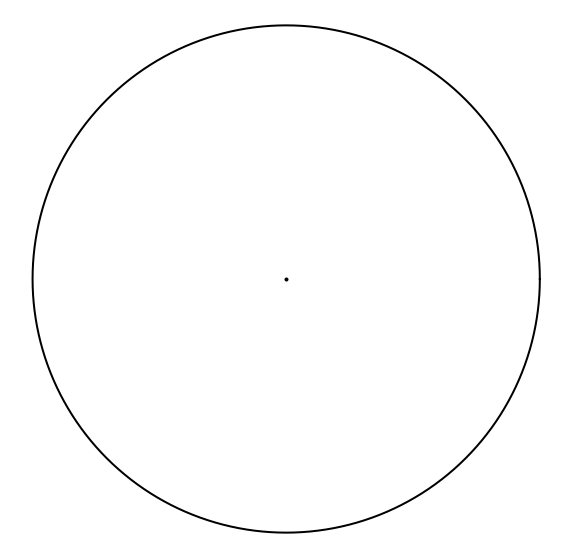

In [94]:
## 4.7.0 Create the arrays t, x, and z
t = np.arange(0,2.01*pi,0.01*pi)
x = 1/2*pi*cos(t)
y = 1/2*pi*...

# 4.7.0 Plot the Circle 
plt.figure(figsize=(10, 10))
plt.plot(x,y,'k',linewidth=2)
plt.axis('equal')
plt.axis('off')
plt.plot(0,0,'.k',linewidth=3)

___
### 4.7.1 Add the sky plot titles
 
Set the title of the plot to *Sky Plot*, with font size 24, On the second line at the geodetic latitude and longitude,  in ddd-mm-ss.sss, the name of the reference ellipsoid and the epoch in human readable form in UTC

Text(0.5, 1.0, 'For pos: $\\phi$: 30$^{\\circ}$15\'0.00"  $\\lambda$: -89$^{\\circ}$-37\'-12.00" WGS-84 at epoch: Mon Aug 29 15:00:00 2005 UTC')

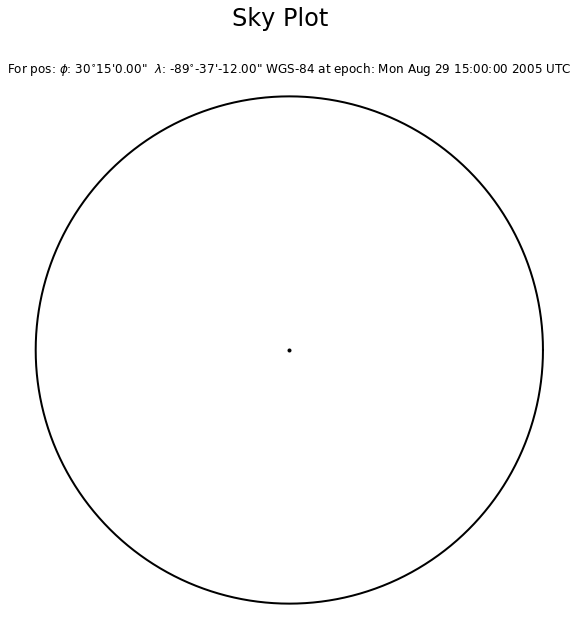

In [95]:
## 4.7.0 Create the arrays t, x, and z

... # Copy the completed code from # 4.7.0 here

# 4.7.1 Add the Suptitle 'Sky Plot' in font size 24
plt.suptitle('...', fontsize = 24)
str_pos = r'$\phi$: '
pos = lat*180/pi
str_pos += str(int(pos))
pos = (pos-int(pos))*60
str_pos += '$^{\circ}$'+str(int(pos))
pos = (pos-int(pos))*60
str_pos += '\'%.2f'%pos+'\"'
str_pos += '  $\lambda$: '
pos = lon*180/pi
str_pos += str(int(...))
pos = (pos-...)*60
str_pos += '$^{\circ}$'+...
pos = ...
str_pos += ...
plt.title('For pos: ' + str_pos + ' WGS-84 at epoch: ' + epoch.strftime('%c') + ' UTC')

___
### 4.7.2 Plot The Satellite Locations

Transform the satellite polar topocentric coordinates to coordinates projected within the circle created in 3.5.1.  The mapping function i.e., transform, is to plot the satellites relative to the receiver in a polar plot with the direction defined by the azimuth and the range by the zenith angle, which is the 1/2 pi complement of the elevation. The location will be indicated by a colored dot coded by satellite type; GPS satellites will be colored red and GLONASS satellites blue. A label using the same color-coding and with as its contents the PRN number will be plotted for each satellite.

Note that you will be using the function 'plot' rather than the more obvious 'polar'. The reason for this is that it is much easier to attain the desired behavior using the plot command. However, it does require that we transform our polar topocentric coordinates to a set of 2D Cartesian
Coordinates (not the same as the ones that you determined in 3.1.1!)
 
The transformation is a simple decomposition of the [az elev] polar vector in x and y components.

Plot all the satellites using a red dot for GPS and a blue dot for GLONASS
 
Now label all the satellites using the ‘text’ function and the same color-coding.



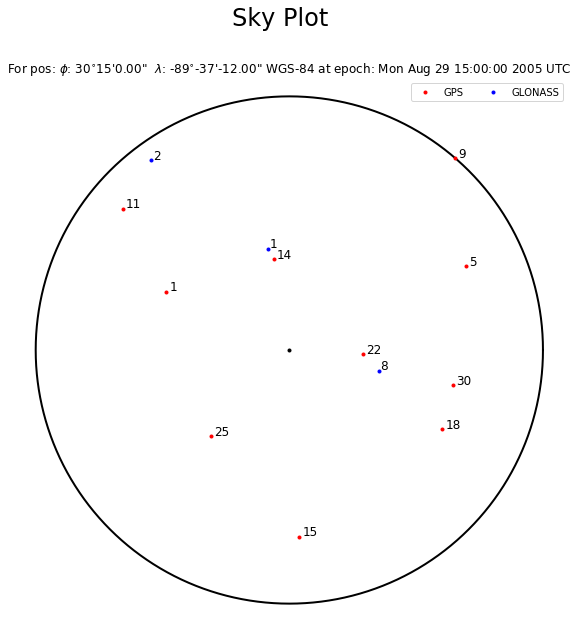

In [96]:
## 4.7.0 Create the arrays t, x, and z

... # Copy the completed code from # 4.7.0 here

# 4.7.1 Add the Suptitle 'Sky Plot' in font size 24

... # Copy the completed code from # 4.7.1 here

# 4.7.2 Transform the polar coordinates to plot coordiniates for the GPS satellites
x_plot = (pi/2-p_az_elev_gps[visible_gps,3:4])*sin(p_az_elev_gps[visible_gps,2:3])
y_plot = (pi/2-p_az_elev_gps[visible_gps,3:4])*cos(p_az_elev_gps[visible_gps,2:3])
# Plot the visible GPS satellites, make sure that we may add a legend
plt.plot(x_plot,y_plot,'r.',label=u'GPS')
# Label the visible GPS satellites with their PRN Codes
for i, prn in enumerate(p_az_elev_gps[visible_gps,:]):
    plt.text(x_plot[i]+.01+.01,y_plot[i]+.01,str(int(prn[0])), fontsize = 12)
# Transform the polar coordinates to plot coordiniates for the GLONASS satellites
x_plot = (pi/2-p_az_elev_gln[...)*sin(p_az_elev_gln[...])
y_plot = ...
# Plot the visible GLONASS satellites, make sure that we may add a legend
plt.plot(x_plot,y_plot,'b.',label=u'GLONASS')
# Label the visible GLONASS satellites with their PRN Codes
for i, prn in enumerate(p_az_elev_gln[visible_gln,:]):
    ...

    
plt.legend(ncol=2, loc='upper right')    
plt.show()